# Classification and Clustering Algorithms paired with Wine and Chocolate
------
<img src="images/wineAndChocolate.jpg" width="500" height="500">

## A demo using DataStax Enterprise Analytics, Apache Cassandra, Apache Spark, Python, Jupyter Notebooks, Spark MlLib, and KMeans 

#### Real Dataset: https://archive.ics.uci.edu/ml/datasets/wine

## What are we trying to learn from this dataset? 

# QUESTION:  Using qualities of a wine, can it's vineyard be determined? (Can we find it's "cluster"?)


## Import python packages -- all are required
* Need to tell Jupyter to display with %matplotlib otherwise you will generate the plot but not display it

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas
import cassandra
import pyspark
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

#### Helper function to have nicer formatting of Spark DataFrames

In [3]:
#Helper for pretty formatting for Spark DataFrames
def showDF(df, limitRows =  5, truncate = True):
    if(truncate):
        pandas.set_option('display.max_colwidth', 50)
    else:
        pandas.set_option('display.max_colwidth', -1)
    pandas.set_option('display.max_rows', limitRows)
    display(df.limit(limitRows).toPandas())
    pandas.reset_option('display.max_rows')

# DataStax Enterprise Analytics
<img src="images/dselogo.png" width="400" height="200">

## Creating Tables and Loading Tables

### Connect to DSE Analytics Cluster

In [4]:
from cassandra.cluster import Cluster

cluster = Cluster(['127.0.01'])
session = cluster.connect()

### Create Demo Keyspace 

In [5]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS wineChocolate 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

### Set keyspace 

In [6]:
session.set_keyspace('winechocolate')

### Create table called wine. Our PRIMARY will be a unique key (wineid) we generate for each row. This will result in an even distribution of the data but we will have to utilize that PRIMARY KEY in our WHERE clause in any of our CQL queries. 

In [7]:
query = "CREATE TABLE IF NOT EXISTS wine \
                                   (wineid int, cluster int, alcohol float, malic_acid float, \
                                   ash float, alcalinity_ash float, magnesium float, total_phenols float, \
                                   flavanoids float, nonflavanoid_phenols float, proanthocyains float, \
                                   color_intensity float, hue float, protein float, proline float, \
                                   PRIMARY KEY (wineId))"
session.execute(query)


### What do these of these 15 columns represent: 

* **Wineid**: Unique key created for each wine

* **Cluster**: Which vindyard this wine belongs to -- And what we will be using Kmeans to determine 1-3

* **Alcohol**: alcohol content, reported in units of ABV (alcohol by volume).

* **Malic acid**: one of the principal organic acids found in wine. Although found in nearly every fruit and berry, it’s flavor is most prominent in green apples; likewise, it projects this sour flavor into wine. For more information, feel free to read about acids in wine.

* **Ash**: yep, wine has ash in it. Ash is simply the inorganic matter left after evaporation and incineration.

* **Alcalinity of ash**: the alkalinity of ash determines how basic (as opposed to acidic) the ash in a wine is.

* **Magnesium**: magnesium is a metal that affects the flavor of wine.

* **Total phenols**: Phenols are chemicals that affect the taste, color, and mouthfeel (i.e., texture) of wine. For some (very) in-depth information about phenols, we refer you to phenolic content in wine.

* **Flavoids** : flavonoids are a type of phenol.

* **Nonflavoid phenols**: nonflavonoids are another type of phenol.

* **Proanthocyanins**: proanthocyanidins are yet another type of phenol.

* **Color intensity**: the color intensity of a wine: i.e., how dark it is.

* **Hue**: the hue of a wine, which is typically determined by the color of the cultivar used (although this is not always the case).

* **Protein**: protein content measurements. --Renamed to protein 

* **Proline**: an amino acid present in wines.

Reference: https://cs.brown.edu/courses/cs100/homework/homework-3-part-ii/

### Load Wine Dataset
<img src="images/wines.jpeg" width="300" height="300">

### Load Wine dataset from CSV file (wine.csv)
* No clean up was requried! How nice :)

#### Insert all the Wine Data into the Apache Cassandra table `wine`

In [8]:
fileName = 'data/wine.csv'
input_file = open(fileName, 'r')
i = 1
for line in input_file:
    wineId = i
    tweets = line.split(',')
    query = "INSERT INTO wine (wineid, cluster, alcohol, malic_acid, ash, alcalinity_ash, \
                               magnesium, total_phenols, flavanoids, nonflavanoid_phenols, \
                               proanthocyains, color_intensity, hue, protein, proline)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (wineId, int(tweets[0]), float(tweets[1]), float(tweets[2]), float(tweets[3]), 
                    float(tweets[4]), float(tweets[5]), float(tweets[6]), float(tweets[7]), float(tweets[8]),
                    float(tweets[9]), float(tweets[10]), float(tweets[11]), float(tweets[12]), float(tweets[13])))
    i = i + 1

#### Do a select * on wine WHERE wineid = x to verify that data was loaded into the table

In [9]:
query = 'SELECT * FROM wine WHERE wineid = 150'
rows = session.execute(query)
for row in rows:
    print (row.wineid, row.cluster, row.alcohol, row.malic_acid, row.ash, row.alcalinity_ash,
           row.magnesium, row.total_phenols, row.flavanoids, row.nonflavanoid_phenols,
           row.proanthocyains, row.color_intensity, row.hue, row.protein, row.proline)

(150, 3, 13.079999923706055, 3.9000000953674316, 2.359999895095825, 21.5, 113.0, 1.409999966621399, 1.3899999856948853, 0.3400000035762787, 1.1399999856948853, 9.399999618530273, 0.5699999928474426, 1.3300000429153442, 550.0)


## DSE Analytics with Apache Spark
<img src="images/sparklogo.png" width="150" height="200">

### Finally time for Apache Spark! 

#### Create a spark session that is connected to Cassandra. From there load each table into a Spark Dataframe and take a count of the number of rows in each.

In [10]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()


wineTable = spark.read.format("org.apache.spark.sql.cassandra").options(table="wine", keyspace="winechocolate").load()

print ("Table Row Count: ")
print (wineTable.count())

Table Row Count: 
178


In [11]:
showDF(wineTable)

,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols
0,4,16.799999,14.37,2.50,1,7.8,3.49,0.86,113.0,1.95,0.24,2.18,1480.0,3.45,3.85
1,18,20.000000,13.83,2.62,1,6.6,3.40,1.13,115.0,1.57,0.40,1.72,1130.0,2.57,2.95
2,177,20.000000,13.17,2.37,3,9.3,0.68,0.60,120.0,2.59,0.53,1.46,840.0,1.62,1.65
3,51,12.400000,13.05,2.04,1,7.2,3.27,1.12,92.0,1.73,0.17,2.91,1150.0,2.91,2.72
4,47,16.000000,14.38,2.28,1,4.9,3.17,1.04,102.0,3.59,0.27,2.19,1065.0,3.44,3.25


## Let's visualize this data with a scatter plot 
### The x axis will be alcohol content  
### The y axis will be protein 
### The color of the dot will be assigned based on its "cluster" or Vineyard. 

Note: These values are just to give us a plot for each wine that does not overlap
Note 1: Must move to a Pandas dataframe to do this visualization (be aware! This can't always be done as is, depends on your data size)

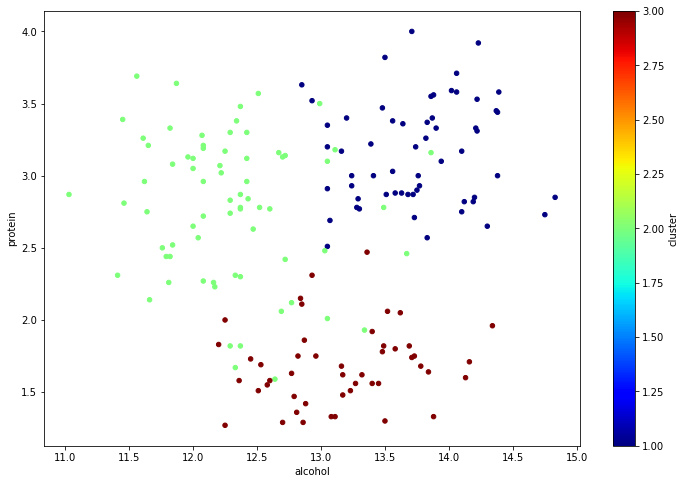

In [12]:
winedf = wineTable.toPandas()
winedf.plot.scatter(x = 'alcohol', y = 'protein', c= 'cluster', figsize=(12,8), colormap='jet')

### Wines from Vineyard 3 are represented as red, Vineyard  1 is blue, and Vineyard 2 is green. 

## Let's see if Kmeans can give us the same clustering. 

## K-means clustering is a simple unsupervised learning algorithm that is used to solve clustering problems. Kmeans is very simple, but very powerful even on large datasets. It requires that all the input columns be vectorized. We have used all the columns in our dataset except for cluster, and windId.

https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

In [13]:
assembler = VectorAssembler(
    inputCols=[ 'alcalinity_ash', 'alcohol', 'ash', 
               'color_intensity', 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                'proline', 'total_phenols'],
    outputCol='features')

trainingData1 = assembler.transform(wineTable)

### We need to set the K for KMeans which we will set at 3. One of the downsides of unsupervised learning is that we normally will not have clusteres predefinded (like we do in this case). Kmeans will happily split the data into as many clusters as you set. 

#### First we will generate the model and then make predictions based on that model 

In [14]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData1)

# Make predictions
predictions = model.transform(trainingData1)

showDF(predictions)

,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61,"[16.600000381469727, 13.710000038146973, 2.359...",2
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48,"[21.0, 11.40999984741211, 2.5, 3.0799999237060...",0
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88,"[14.0, 13.819999694824219, 2.4200000762939453,...",1
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74,"[20.0, 11.609999656677246, 2.700000047683716, ...",0
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60,"[18.5, 12.079999923706055, 2.319999933242798, ...",0


## In this case because we are actually preforming surpervised learnings (since we do have the cluster labels) we can do some comparisions to see if our predictions are correct. 
## Some ways to do this are confusion matrix, or matching matrix. 
## In this case I am just taking a look at the counts for each group. 

In [15]:
predictions.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   27|
|         2|   49|
|         0|  102|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



## Let's create another scatter plot to see if this lines up with our orignal scatter plot. 

## Everything is the same except now our dots will represent the color of the prediction (instead of the orginal cluster)

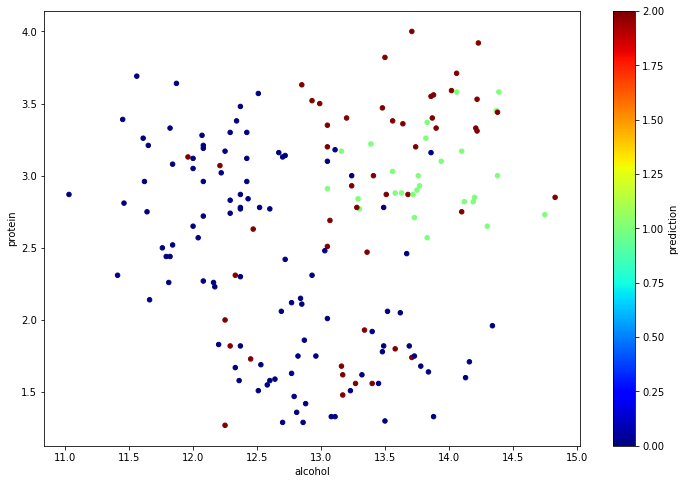

In [16]:
wine_df = predictions.toPandas()

wine_df.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

### The wines from Vineyard 1 seem to be the best identified as a group (labeled in green) but Vineyard 2 and 3 are not as clearly definded as before. 

## Other downside of KMeans is that is struggles when you add many variables. Let's get rid of some of our columns and run this again. 

### Let's remove any column that we think is an external factor that would effect the wine but not the actual plant that is grown by the winary 
* Alcohol
* Ash
* Alcalinity of Ash
* Color intensity -- but we will keep hue as the hue is determined by the type of cultivar used

In [17]:
assembler = VectorAssembler(
    inputCols=[ 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                'proline', 'total_phenols'],
    outputCol='features')

trainingData0 = assembler.transform(wineTable)

In [18]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData0)

# Make predictions
predictions0 = model.transform(trainingData0)

showDF(predictions0)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61,"[4.0, 2.880000114440918, 1.1100000143051147, 1...",1
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48,"[2.309999942779541, 2.009999990463257, 1.10000...",0
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88,"[3.259999990463257, 3.740000009536743, 1.00999...",1
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74,"[3.259999990463257, 2.9200000762939453, 0.9599...",2
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60,"[2.2699999809265137, 1.5, 1.0800000429153442, ...",0


### Our counts are looking better when we just roughly compare

In [19]:
predictions0.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   47|
|         2|   62|
|         0|   69|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



## How does our new scatter plot compare? 

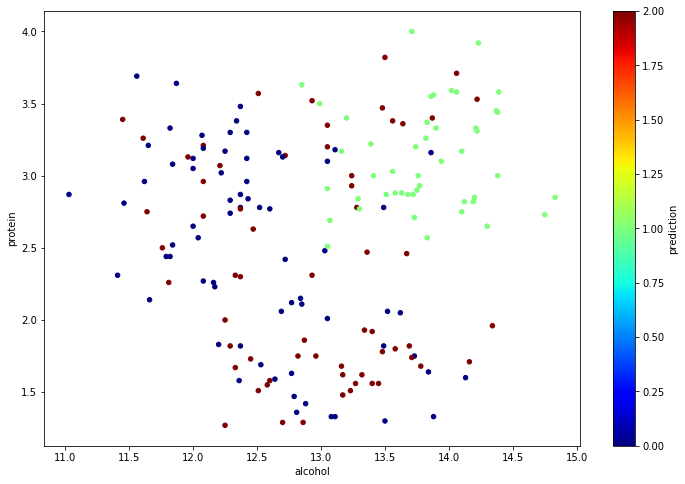

In [20]:
wine_df0 = predictions0.toPandas()

wine_df0.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

## Vineyard 1 is still being labled correctly (it just so happpens to also be labeled at 1), but still struggling on Vineyard 2 and 3 

### Let's remove more columns and run Kmeans again

In [21]:
assembler = VectorAssembler(
    inputCols=[ 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid'],
    outputCol='features')

trainingData2 = assembler.transform(wineTable)

In [22]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData2)

# Make predictions
predictions2 = model.transform(trainingData2)

showDF(predictions2)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,4,16.799999,14.37,2.50,1,7.8,3.49,0.86,113.0,1.95,0.24,2.18,1480.0,3.45,3.85,"[3.450000047683716, 3.490000009536743, 0.86000...",1
1,18,20.000000,13.83,2.62,1,6.6,3.40,1.13,115.0,1.57,0.40,1.72,1130.0,2.57,2.95,"[2.569999933242798, 3.4000000953674316, 1.1299...",1
2,177,20.000000,13.17,2.37,3,9.3,0.68,0.60,120.0,2.59,0.53,1.46,840.0,1.62,1.65,"[1.6200000047683716, 0.6800000071525574, 0.600...",1
3,51,12.400000,13.05,2.04,1,7.2,3.27,1.12,92.0,1.73,0.17,2.91,1150.0,2.91,2.72,"[2.9100000858306885, 3.2699999809265137, 1.120...",0
4,47,16.000000,14.38,2.28,1,4.9,3.17,1.04,102.0,3.59,0.27,2.19,1065.0,3.44,3.25,"[3.440000057220459, 3.1700000762939453, 1.0399...",2


In [23]:
predictions2.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   37|
|         2|   76|
|         0|   65|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



In [24]:
## Let's looks at our scatter plot again

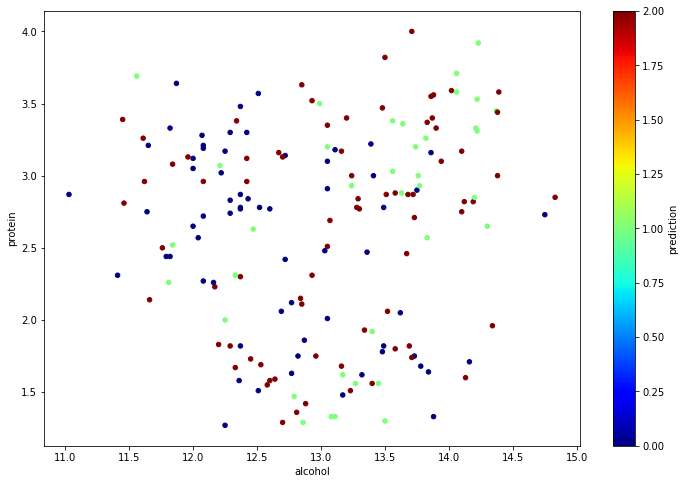

In [25]:
wine_df2 = predictions2.toPandas()

wine_df2.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

### Looks like we have removed too many varibles, and now our three clusters are not lining up to our orginally clusters. 

### What if we try to do just 2 variables, the ones actually use in our scatter plot and see if that does the trick

In [26]:
assembler = VectorAssembler(
    inputCols=['alcohol', 'protein'],
    outputCol='features')

trainingData3 = assembler.transform(wineTable)

In [27]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData3)

# Make predictions
predictions3 = model.transform(trainingData3)

showDF(predictions3)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61,"[13.710000038146973, 4.0]",1
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48,"[11.40999984741211, 2.309999942779541]",2
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88,"[13.819999694824219, 3.259999990463257]",1
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74,"[11.609999656677246, 3.259999990463257]",2
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60,"[12.079999923706055, 2.2699999809265137]",2


In [28]:
predictions3.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   65|
|         2|   55|
|         0|   58|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



### And let's look at our scatter plot to validate the data

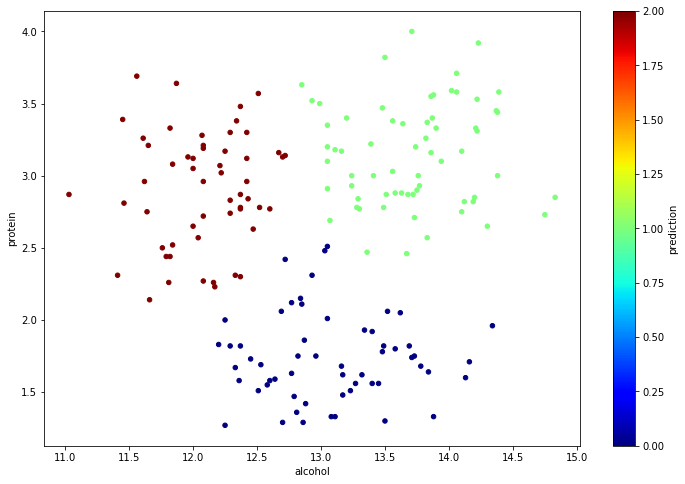

In [29]:
wine_df3 = predictions3.toPandas()

wine_df3.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

## WHOA! That was it! The alcohol content of the wine, and its protein amount are the strong indicators that that wine belongs to a particular vineyard! 

# Remember Data Science and analytics is an iterative process! It's a science! Hypothesis, test, analysis, and loop again! 

In [30]:
session.execute("""drop table wine""")

References: 
* https://sweetcode.io/k-means-clustering-python/ 

* https://cs.brown.edu/courses/cs100/homework/homework-3-part-ii/

* https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html 

* https://en.wikipedia.org/wiki/K-means_clustering

* https://rsandstroem.github.io/sparkkmeans.html

* https://imaddabbura.github.io/post/kmeans_clustering/